# 代价函数
---
$J\left( \theta  \right)=\frac{1}{2m} \Bigg[ \sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}} + \lambda \sum\limits_{j=1}^{n} \theta_{j}^2 \Bigg]$  
${{h}_{\theta }}\left( x \right)={{\theta }^{T}}X={{\theta }_{0}}{{x}_{0}}+{{\theta }_{1}}{{x}_{1}}+{{\theta }_{2}}{{x}_{2}}+...+{{\theta }_{n}}{{x}_{n}}$    

In [1]:
def linearRegressionLossAndGrad(X, y, theta, v_lambda):
    
    #np.hstack((a,b)) 行合并
    #np.vstack((a,b)) 列合并
    
    # X @ theta = X.dot(theta)
    
	m = X.shape[0];
	theta_without_bias = np.matrix(theta, copy=True)
	theta_without_bias[0,0] = 0
    
	J = (1/2/m) * (X @ theta - y).T @ (X @ theta - y) + (v_lambda/2/m) * np.sum(np.power(theta_without_bias, 2)); 
    #J = np.sum(np.power(((X @ theta.T) - y), 2)) / (2 * m);
	grad = X.T @ (X @ theta - y) / m + v_lambda * theta_without_bias / m;
	return J, grad

# Batch Gradient Decent（批量梯度下降）
---
${{\theta }_{j}}:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right)$  
$\frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right) = \frac{1}{m}\sum\limits_{i=1}^{m}{{{\Big( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \Big) \cdot {x}_{j}^{(i)} }}} + \frac{\lambda}{m} \cdot \theta_{j}$ 

In [2]:
def batch_gradient_descent(X, y, initial_theta, epoch, alpha, v_lambda):
	J_set = list();
	
	theta = initial_theta.copy();
	for iter in range(epoch):
		[J, grad] = linearRegressionLossAndGrad(X, y, theta, v_lambda);
		J_set.append(J[0, 0]);
		theta = theta - alpha * grad;
	return theta, J_set

# 多项式特征映射
---
```Octave
function X_poly = polynomialFeaturesMap(X, p)
n = size(X, 2);
% X1, X1.^2, X1.^3, etc...
if n == 1,
	X_poly = zeros(numel(X), p);
	for j = 1:p
		X_poly(:,j) = X .^ j;
	end;
	%X_poly = [ones(size(X_poly),1) X_poly];
	%disp(n);
% X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
elseif n == 2,
	degree = p;
	X1 = X(:,1);
	X2 = X(:,2);
	X_poly = ones(size(X1(:,1)));
	for i = 1:degree
		for j = 0:i
			X_poly(:, end+1) = (X1.^(i-j)).*(X2.^j);
		end
	end;
	%disp(n);
else 
	X_poly = 0;
	%disp(n);
end;
end
```

In [3]:
# 多项式特征映射
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [4]:
def learningCurve(X, y, Xcv, ycv, Xtest, ytest, epoch, alpha, v_lambda):
    m = X.shape[0];    
    error_train = np.zeros([m, 1]);
    error_cv = np.zeros([m, 1]);
    error_test = np.zeros([m, 1]);
    initial_theta = np.zeros([X.shape[1], 1]); 
    
    for i in range(m):
        [theta, J_set] = batch_gradient_descent(X[0:i+1, :], y[0:i+1,:], initial_theta, epoch, alpha, v_lambda)
        
        [J, grad] = linearRegressionLossAndGrad(X[0:i+1,:], y[0:i+1,:], theta, v_lambda);
        error_train[i] = J;
        
        [J, grad] = linearRegressionLossAndGrad(Xcv, ycv, theta, v_lambda);
        error_cv[i] = J;
        
        [J, grad] = linearRegressionLossAndGrad(Xtest, ytest, theta, v_lambda);
        error_test[i] = J;
    
    return error_train, error_cv, error_test

In [21]:
def modelSelectionCurve(X, y, Xcv, ycv, Xtest, ytest, p, epoch, alpha, lambda_vec):

    polynomial_degree_vec = np.zeros([p, 1]);
    for i in range(p): polynomial_degree_vec[i] = i + 1;
        
    # You need to return these variables correctly.
    error_train = np.zeros([lambda_vec.shape[0], p]);
    error_cv    = np.zeros([lambda_vec.shape[0], p]);
    error_test  = np.zeros([lambda_vec.shape[0], p]);

    for i in range(lambda_vec.shape[0]):
        
        print('Computing lambda = ' + str(lambda_vec[i,0]))
        
        for j in range(p):

            # Map X onto Polynomial Features and Normalize
            X_poly = poly_features(X, power=j + 1, as_ndarray=False) # DataFrame format
            # polynomial + normalize + bias + matrix
            X_pnbm = (X_poly - X_poly.mean()) / X_poly.std()
            X_pnbm.insert(0, 'Ones', 1) # add bias
            X_pnbm = np.matrix(X_pnbm.iloc[:,:])

            # Map X_poly_cv and normalize (using mu and sigma)
            X_poly_cv = poly_features(Xcv, power=j + 1, as_ndarray=False) # DataFrame format
            # polynomial + normalize + bias + matrix
            X_pnbm_cv = (X_poly_cv - X_poly.mean()) / X_poly.std()
            X_pnbm_cv.insert(0, 'Ones', 1) # add bias
            X_pnbm_cv = np.matrix(X_pnbm_cv.iloc[:,:])

            # Map X_poly_test and normalize (using mu and sigma)
            X_poly_test = poly_features(Xtest, power=j + 1, as_ndarray=False) # DataFrame format
            # polynomial + normalize + bias + matrix
            X_pnbm_test = (X_poly_test - X_poly.mean()) / X_poly.std()
            X_pnbm_test.insert(0, 'Ones', 1) # add bias
            X_pnbm_test = np.matrix(X_pnbm_test.iloc[:,:])
        
            # training model
            initial_theta     = np.zeros([X_pnbm.shape[1], 1]); 
            [theta, J_set] = batch_gradient_descent(X_pnbm, y, initial_theta, epoch, alpha, lambda_vec[i,0])
        
            # compute error
            [error_train[i, j], grad] = linearRegressionLossAndGrad(X_pnbm, y, theta, lambda_vec[i,0]);
            [error_cv[i, j], grad]    = linearRegressionLossAndGrad(X_pnbm_cv, ycv, theta, lambda_vec[i,0]);
            [error_test[i, j], grad]  = linearRegressionLossAndGrad(X_pnbm_test, ytest, theta, lambda_vec[i,0]);

    return polynomial_degree_vec, error_train, error_cv, error_test

In [5]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
d = sio.loadmat('ex5data1.mat')
X, y, X_cv, y_cv, X_test, y_test = map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [7]:
# add bias unit
X_m, X_vc_m, X_test_m = [x.reshape(x.shape[0], 1) for x in (X, X_cv, X_test)]
X_m = np.matrix(X_m)
X_vc_m = np.matrix(X_vc_m)
X_test_m = np.matrix(X_test_m)

X_bias, X_cv_bias, X_test_bias = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, X_cv, X_test)]
X_bias_m = np.matrix(X_bias)
X_cv_bias_m = np.matrix(X_cv_bias)
X_test_bias_m = np.matrix(X_test_bias)

y_m, y_cv_m, y_test_m = [x.reshape(x.shape[0], 1) for x in (y, y_cv, y_test)]
y_m = np.matrix(y_m)
y_cv_m = np.matrix(y_cv_m)
y_test_m = np.matrix(y_test_m)

X_poly = poly_features(X, power=8, as_ndarray=False) # DataFrame format
v_mean=X_poly.mean()
v_std=X_poly.std()
X_poly_normalize = (X_poly - X_poly.mean()) / X_poly.std()
X_poly_normalize.insert(0, 'Ones', 1) # add bias
X_poly_normalize_bias_m = np.matrix(X_poly_normalize.iloc[:,:])

X_cv_poly = poly_features(X_cv, power=8, as_ndarray=False) # DataFrame format
v_mean=X_cv_poly.mean()
v_std=X_cv_poly.std()
X_cv_poly_normalize = (X_cv_poly - X_cv_poly.mean()) / X_cv_poly.std()
X_cv_poly_normalize.insert(0, 'Ones', 1) # add bias
X_cv_poly_normalize_bias_m = np.matrix(X_cv_poly_normalize.iloc[:,:])

X_test_poly = poly_features(X_test, power=8, as_ndarray=False) # DataFrame format
v_mean=X_test_poly.mean()
v_std=X_test_poly.std()
X_test_poly_normalize = (X_test_poly - X_test_poly.mean()) / X_test_poly.std()
X_test_poly_normalize.insert(0, 'Ones', 1) # add bias
X_test_poly_normalize_bias_m = np.matrix(X_test_poly_normalize.iloc[:,:])

theta = np.matrix(np.ones([X_bias.shape[1], 1]))

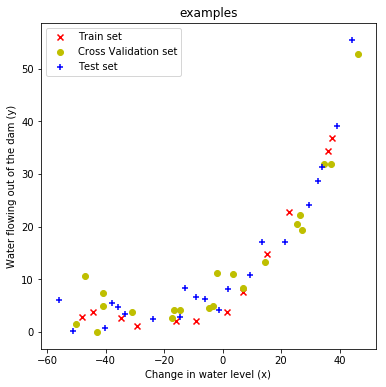

In [8]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(X, y, color='r', marker='x', label="Train set")
plt.scatter(X_cv, y_cv, color='y', marker='o', label="Cross Validation set")
plt.scatter(X_test, y_test, color='b', marker='+', label="Test set")
ax.legend(loc=2)
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')
ax.set_title('examples')
plt.show()

In [9]:
# Test Regularized Linear Regression Cost and Gradient
linearRegressionLossAndGrad(X_bias_m, y_m, theta, 1)

(matrix([[303.99319222]]), matrix([[-15.30301567],
         [598.25074417]]))

# Train Linear Regression
---

In [10]:
batch_gradient_descent(X_bias_m, y_m, theta, 1, 0.01, 0)

(matrix([[ 1.15303016],
         [-4.98167411]]), [303.9515255535976])

In [11]:
# trainning lambad = 0 and poly = 1
v_lambda = 0;
epoch = 7000;
alpha = 0.001;
initial_theta = np.matrix(np.zeros([X_bias_m.shape[1], 1]));

[theta, J_set] = batch_gradient_descent(X_bias_m, y_m, initial_theta, epoch, alpha, v_lambda)

In [12]:
epoch = 21500 # 随着迭代的次数增加，拟合效果会好一些
alpha = 0.3

In [13]:
# trainning lambad = 0 and poly = 8
v_lambda = 0;
initial_theta = np.matrix(np.zeros([X_poly_normalize_bias_m.shape[1], 1]));

[theta_0_8, J_set_0_8] = batch_gradient_descent(X_poly_normalize_bias_m, y_m, initial_theta, epoch, alpha, v_lambda)

In [14]:
# trainning lambad = 1 and poly = 8
v_lambda = 1;
initial_theta = np.matrix(np.zeros([X_poly_normalize_bias_m.shape[1], 1]));

[theta_1_8, J_set_1_8] = batch_gradient_descent(X_poly_normalize_bias_m, y_m, initial_theta, epoch, alpha, v_lambda)

In [15]:
v_lambda = 0;
epoch = 7000;
alpha = 0.001;
[error_train_1, error_cv_1, error_test_1] = learningCurve(X_bias_m, y_m, X_cv_bias_m, y_cv_m, X_test_bias_m, y_test_m, epoch, alpha, v_lambda);
[error_train_8, error_cv_8, error_test_8] = learningCurve(X_poly_normalize_bias_m, y_m, X_cv_poly_normalize_bias_m, y_cv_m, X_test_poly_normalize_bias_m, y_test_m, epoch, alpha, v_lambda);
[error_train_f, error_cv_f, error_test_f] = learningCurve(X_poly_normalize_bias_m, y_m, X_cv_poly_normalize_bias_m, y_cv_m, X_test_poly_normalize_bias_m, y_test_m, epoch, alpha, 1);

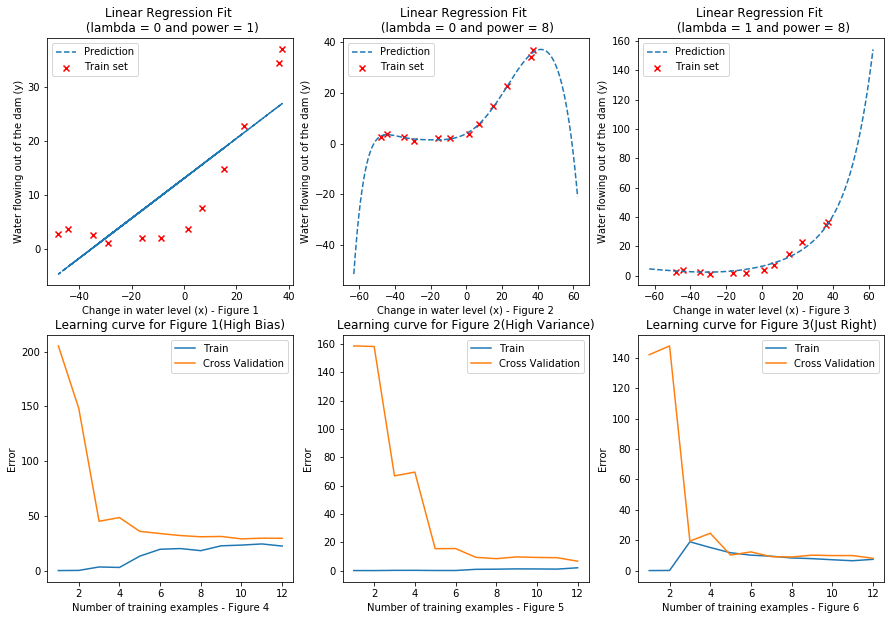

In [32]:
fig = plt.figure(num=1, figsize=(15,10))

ax1 = fig.add_subplot(231)
ax1.scatter(X, y, color='r', marker='x', label="Train set")
ax1.plot(X, X_bias_m @ theta, '--', label="Prediction")
ax1.legend(loc=2)
ax1.set_xlabel('Change in water level (x) - Figure 1')
ax1.set_ylabel('Water flowing out of the dam (y)')
ax1.set_title('Linear Regression Fit \n (lambda = 0 and power = 1)')

m = X_bias.shape[0]
tmp_x = np.arange(start=X.min() - 15, stop=X.max() + 25, step=0.05)
tmp_x_poly =poly_features(tmp_x, power=8, as_ndarray=False) # DataFrame format
tmp_x_poly_normalize = (tmp_x_poly - X_poly.mean()) / X_poly.std()
tmp_x_poly_normalize.insert(0, 'Ones', 1) # add bias
tmp_x_poly_normalize_bias_m = np.matrix(tmp_x_poly_normalize.iloc[:,:])

ax2 = fig.add_subplot(232)
ax2.scatter(X, y, color='r', marker='x', label="Train set")
ax2.plot(tmp_x, tmp_x_poly_normalize_bias_m @ theta_0_8, '--', label="Prediction")
ax2.legend(loc=2)
ax2.set_xlabel('Change in water level (x) - Figure 2')
ax2.set_ylabel('Water flowing out of the dam (y)')
ax2.set_title('Linear Regression Fit \n (lambda = 0 and power = 8)')

ax3 = fig.add_subplot(233)
ax3.scatter(X, y, color='r', marker='x', label="Train set")
ax3.plot(tmp_x, tmp_x_poly_normalize_bias_m @ theta_1_8, '--', label="Prediction")
ax3.legend(loc=2)
ax3.set_xlabel('Change in water level (x) - Figure 3')
ax3.set_ylabel('Water flowing out of the dam (y)')
ax3.set_title('Linear Regression Fit \n (lambda = 1 and power = 8)')

ax4 = fig.add_subplot(234)
ax4.plot(range(1,m+1), error_train_1, label='Train')
ax4.plot(range(1,m+1), error_cv_1, label='Cross Validation')
ax4.legend(loc=0)
ax4.set_xlabel('Number of training examples - Figure 4')
ax4.set_ylabel('Error')
ax4.set_title('Learning curve for Figure 1(High Bias)')

ax5 = fig.add_subplot(235)
ax5.plot(range(1,m+1), error_train_8, label='Train')
ax5.plot(range(1,m+1), error_cv_8, label='Cross Validation')
ax5.legend(loc=0)
ax5.set_xlabel('Number of training examples - Figure 5')
ax5.set_ylabel('Error')
ax5.set_title('Learning curve for Figure 2(High Variance)')

ax6 = fig.add_subplot(236)
ax6.plot(range(1,m+1), error_train_f, label='Train')
ax6.plot(range(1,m+1), error_cv_f, label='Cross Validation')
ax6.legend(loc=0)
ax6.set_xlabel('Number of training examples - Figure 6')
ax6.set_ylabel('Error')
ax6.set_title('Learning curve for Figure 3(Just Right)');

In [17]:
te=np.array([range(1, 13)]).T.astype(int);

In [18]:
L0P1=np.hstack((te, np.around(error_train_1, decimals=8), np.around(error_cv_1, decimals=8), np.around(error_test_1, decimals=8)))
pd.DataFrame(L0P1, columns=['Training Examples','Train Error','Cross Validation Error','Test Error'])

,Training Examples,Train Error,Cross Validation Error,Test Error
0,1.0,0.000000,205.121096,238.968432
1,2.0,0.141759,148.209792,174.697397
2,3.0,3.286690,45.015644,41.326025
3,4.0,2.842855,48.408832,43.716019
4,5.0,13.154193,35.819772,32.989797
5,6.0,19.444092,33.813695,31.982672
6,7.0,20.098610,31.975242,31.678280
7,8.0,18.173002,30.856435,30.814665
8,9.0,22.609515,31.150572,32.397108
9,10.0,23.261703,28.944734,31.138211


In [19]:
# Polynomial Regression
L0P8=np.hstack((te, np.around(error_train_8, decimals=8), np.around(error_cv_8, decimals=8), np.around(error_test_8, decimals=8)))
pd.DataFrame(L0P8, columns=['Training Examples','Train Error','Cross Validation Error','Test Error'])

,Training Examples,Train Error,Cross Validation Error,Test Error
0,1.0,0.000000,158.574519,183.672180
1,2.0,0.001114,158.188619,183.121835
2,3.0,0.145675,66.845233,69.800472
3,4.0,0.166527,69.508667,72.421671
4,5.0,0.055987,15.467526,11.148458
5,6.0,0.047623,15.548999,11.111492
6,7.0,0.870065,9.348289,7.372427
7,8.0,0.992566,8.400116,7.011602
8,9.0,1.188649,9.631750,7.729722
9,10.0,1.134592,9.264892,7.663120


In [20]:
L1P1=np.hstack((te, np.around(error_train_f, decimals=8), np.around(error_cv_f, decimals=8), np.around(error_test_f, decimals=8)))
pd.DataFrame(L1P1, columns=['Training Examples','Train Error','Cross Validation Error','Test Error'])

,Training Examples,Train Error,Cross Validation Error,Test Error
0,1.0,0.011819,141.969994,167.741171
1,2.0,0.082657,147.750886,173.311207
2,3.0,18.929405,19.398451,24.990685
3,4.0,15.181235,24.558575,27.530675
4,5.0,11.727952,10.187336,12.388606
5,6.0,10.152380,12.301498,13.817985
6,7.0,9.462124,9.160031,11.338593
7,8.0,8.313390,8.948530,11.298106
8,9.0,7.857416,10.142667,12.111877
9,10.0,7.124100,9.872218,12.042113


# Selecting Lambda / polynomial degree / Computing test set error
---

In [22]:
#lambda_vec = [0, 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24];
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3];
lambda_vec = np.array(lambda_vec).reshape(len(lambda_vec),1);

p = 10;
epoch = 5000;
alpha = 0.23;
[polynomial_degree_vec, error_train, error_cv, error_test] = modelSelectionCurve(X, y_m, X_cv, y_cv_m, X_test, y_test_m, p, epoch, alpha, lambda_vec);

Computing lambda = 0.0
Computing lambda = 0.001
Computing lambda = 0.003
Computing lambda = 0.01
Computing lambda = 0.03
Computing lambda = 0.1
Computing lambda = 0.3
Computing lambda = 1.0
Computing lambda = 3.0


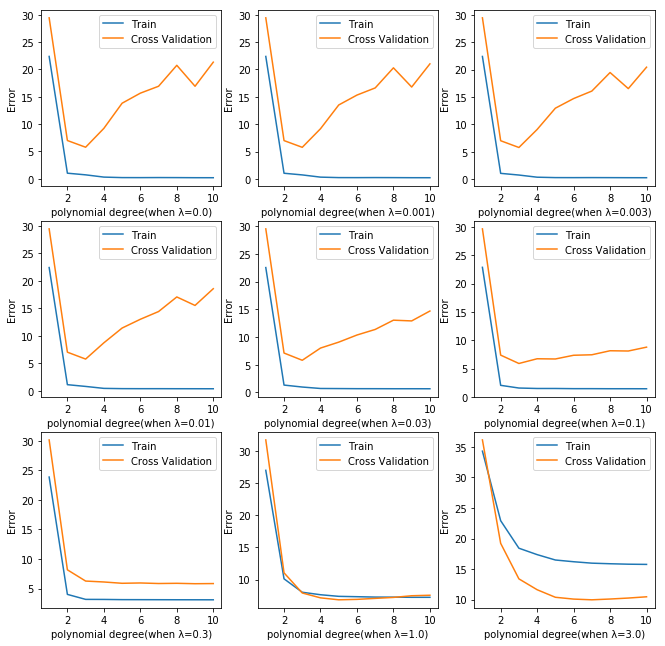

In [23]:
fig = plt.figure(num=2, figsize=(11,11))

for i in range(1, lambda_vec.shape[0]+1):
	ax = fig.add_subplot(3, 3, i)
	ax.plot(polynomial_degree_vec, error_train[i-1, :], label='Train')
	ax.plot(polynomial_degree_vec, error_cv[i-1, :], label='Cross Validation')
	ax.legend(loc=0)
	ax.set_xlabel('polynomial degree(when λ='+str(lambda_vec[i - 1,0])+')')
	ax.set_ylabel('Error')
	#ax.set_title('lambda = ' + str(lambda_vec[i - 1,0]))

上面横着数第八张图片中，当多项式次数等于8时，最优（训练误差和交叉验证误差非常接近且位于很低的位置）。 

个人的一些直觉，不绝对：  
让alpha在允许范围内尽可能大（范围判断：范围外时程序会产生warning，无效值），让梯度下降的步伐大一点（迭代快一些，不然好慢），然后迭代次数多一些，目的是确保梯度下降逼近最优值。
当梯度下降迭代的次数逐渐增多，theta会逐渐接近最优值，但在此过程中，theta的解会呈现出先高偏差，然后差不多正好，再然后，当接近最优解时又变的高方差（过拟合）。 
当然，我们的假设是，lambda=0，也就是没有正则化，而你的模型是高方差的（当梯度下降逼近最优解时）。那么在求解theta的过程中就会呈现出这种情况。记得 Teacher 吴（Andrew Ng）貌似好像也是提过一个概念叫"提前终止"，也就是当你是高方差模型时，可以提前终止梯度下降，那很有可能会得到一个还算不错的解。但是不好把控。所以，我的理解是，一种可以控制的办法是，尽可能逼近最优解，但是用lambda来抑制过拟合，也就是正则化，目的是下降逼近最优解时，模型也是正好拟合的，不高偏差也不高方差。其实正则化下得到的最优解和提前终止时的最优解很可能很接近，只不过，似乎可以变相的理解为，正则化的方法帮我们比较精准的决定了在哪里提前终止是最好的。  

---

下面给出上面9张图的画图数据，可以看到当lambda=1且Power=8时的数据是：训练误差和交叉验证误差非常接近的，且其值很低。并且测试误差也是很低的。测试误差在上图中未画出，所以可通过下面的数据来查看测试误差。  

```
   Lambda  Power  Train Error  Cross Validation Error  Test Error  
      1.0    8.0     7.268148                7.227460    5.692820  
```

可以和其他情况的数据对比来查看和理解

In [24]:
te=np.array([range(1, 11)]).T.astype(int);
for i in range(lambda_vec.shape[0]):
    l = np.array(np.ones([10,1])) * lambda_vec[i,0]
    error_train_m = np.matrix(np.around(error_train[i,:], decimals=8)).T
    error_cv_m = np.matrix(np.around(error_cv[i,:], decimals=8)).T
    error_test_m = np.matrix(np.around(error_test[i,:], decimals=8)).T

    tmp_m=np.hstack((l, te, error_train_m, error_cv_m, error_test_m))
    rst = pd.DataFrame(tmp_m, columns=['Lambda', 'Power','Train Error','Cross Validation Error','Test Error'])
    print(rst)
    print()

   Lambda  Power  Train Error  Cross Validation Error  Test Error
0     0.0    1.0    22.373907               29.433818   32.505749
1     0.0    2.0     1.018661                6.994650    8.011624
2     0.0    3.0     0.716365                5.768795    5.495818
3     0.0    4.0     0.303812                9.216277    9.972814
4     0.0    5.0     0.213785               13.816523   12.706962
5     0.0    6.0     0.208061               15.655634   14.187398
6     0.0    7.0     0.219961               16.920310   14.891692
7     0.0    8.0     0.211070               20.749295   17.892450
8     0.0    9.0     0.194059               16.918090   17.281769
9     0.0   10.0     0.191071               21.325329   22.480930

   Lambda  Power  Train Error  Cross Validation Error  Test Error
0   0.001    1.0    22.378966               29.436133   32.509463
1   0.001    2.0     1.029054                6.998434    8.017137
2   0.001    3.0     0.725102                5.769859    5.496500
3   0.001